In [148]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

## suppress warinings
import warnings
warnings.filterwarnings('ignore')

## Non-linear classification with 2 layer neural network

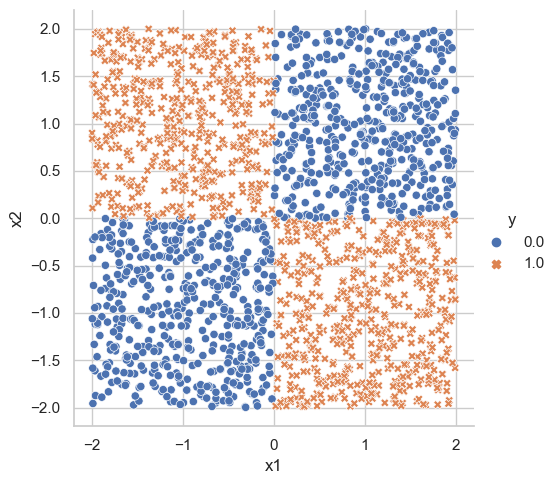

In [156]:

## Generating the data

n = 2000
p = 2
x = np.random.uniform(-2, 2, size=(n, p))
y = ( ((x[:, 0] < 0) & (x[:, 1] > 0)) | ((x[:, 0] > 0) & (x[:, 1] < 0)) ).astype(int)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)

ntrain = 800
x_train = x[:ntrain]
y_train = y[:ntrain]
x_test = x[ntrain:]
y_test = y[ntrain:]

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme(style="whitegrid")
xor_plot = sns.relplot(data=df, x='x1', y='x2', hue='y', style='y')

In [150]:

## defining a two-layer neural network

class NNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, out_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)

        return(x)


def logistic_loss(y_pred, y_true):
    loss_vec = y_true * torch.log(y_pred + 1e-8) + (1 - y_true) * torch.log(1 - y_pred + 1e-8)
    output = -1.0 * torch.mean(loss_vec)
    return(output)


def square_loss(y_pred, y_true):
    loss_vec = (y_true - y_pred) ** 2
    output = torch.mean(loss_vec)
    return(output)



In [151]:
## fit neural network

hidden_dim = 20

model = NNet(x.shape[1], hidden_dim, 1)

# print model weights
print(model.layer1.weight.data)

# model.layer1.weight.data = model.layer1.weight.data * 0

pred = model(x_train)

print(pred)


tensor([[ 0.4304, -0.6708],
        [ 0.1394,  0.3486],
        [ 0.5694, -0.1911],
        [-0.2589,  0.6345],
        [ 0.6054,  0.2350],
        [ 0.3795, -0.0144],
        [-0.1630, -0.5542],
        [ 0.5501, -0.1986],
        [-0.2444, -0.1162],
        [-0.2705, -0.4643],
        [-0.0792,  0.6165],
        [ 0.0988, -0.0138],
        [-0.5384,  0.4042],
        [ 0.0200, -0.3830],
        [-0.4907,  0.3141],
        [-0.4795, -0.4210],
        [ 0.0097,  0.6236],
        [-0.6445,  0.2641],
        [-0.0899, -0.5532],
        [ 0.5191, -0.4507]])
tensor([[0.5710],
        [0.5335],
        [0.5107],
        [0.3939],
        [0.4011],
        [0.4145],
        [0.6801],
        [0.5219],
        [0.6845],
        [0.5176],
        [0.6296],
        [0.5865],
        [0.3587],
        [0.5479],
        [0.5858],
        [0.4404],
        [0.6440],
        [0.6048],
        [0.5715],
        [0.4567],
        [0.5172],
        [0.5432],
        [0.6851],
        [0.5385],
       

In [152]:
## autodifferentiation demo

print(model.layer1.weight.grad)

optimizer = optim.SGD(model.parameters(), lr=0.1)

loss = logistic_loss(pred, y_train)
loss.backward()

# show gradient
# print(model.layer1.weight.grad)

optimizer.step()

# print(model.layer1.weight.data)

optimizer.zero_grad()

None


In [153]:
## stochastic gradient descent

epochs = 300

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=50, shuffle=True)

for i in range(epochs):

    # loss = logistic_loss(model(x_train), y_train.view(-1, 1))
    # loss.backward()
    # optimizer.step()
    # optimizer.zero_grad()

    for x_batch, y_batch in train_loader:
        loss = logistic_loss(model(x_batch), y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if i % 50 == 0:
        print("epoch: " + str(i) + ", loss: " + str(loss.item()))


epoch: 0, loss: 0.669999361038208
epoch: 50, loss: 0.11737393587827682
epoch: 100, loss: 0.07064976543188095
epoch: 150, loss: 0.04166768863797188
epoch: 200, loss: 0.038713179528713226
epoch: 250, loss: 0.04955139756202698


In [154]:
## inspect results

#print("layer1 weights: " + str(model.layer1.weight.data))
#print("layer2 weights: " + str(model.layer2.weight.data))
#print("layer1 bias: " + str(model.layer1.bias.data))

y_pred = model(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = torch.tensor(y_pred, dtype=torch.float).view(-1,1)

test_err = abs(y_pred - y_test).mean()
print(f"Test error: {test_err.item():.3f}")



Test error: 0.002


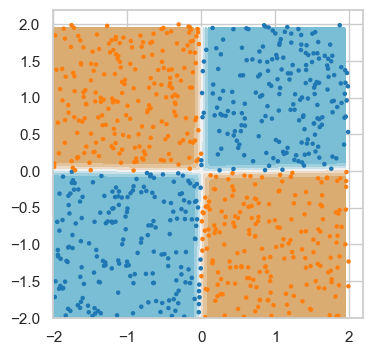

In [155]:
## visualizing prediction contours

x1 = np.arange(-2, 2, 0.05)
x2 = np.arange(-2, 2, 0.05)

x_grid_np = np.array([(i, j) for i in x1 for j in x2])
y_grid_np = ((x_grid_np[:,0] < 0) & (x_grid_np[:, 1] > 0)).astype(int) + \
    ((x_grid_np[:,0] > 0) & (x_grid_np[:, 1] < 0)).astype(int)

x_grid = torch.tensor(x_grid_np, dtype=torch.float)
y_grid = torch.tensor(y_grid_np)

y_pred = model(x_grid)

y_pred_np = y_pred.detach().numpy()
y_pred_np = y_pred_np.reshape(x1.shape[0], x2.shape[0])


seaborn_cols = sns.color_palette("tab10")
cols = [seaborn_cols[int(i)] for i in y_train]

custom_cmap = sns.diverging_palette(220, 50, s=70, l=70, as_cmap=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.contourf(x1, x2, y_pred_np, cmap=custom_cmap)
ax.scatter(x_train[:,0], x_train[:, 1], c=cols, s=5)
